<a href="https://colab.research.google.com/github/dcpatton/malaria-detection/blob/master/malaria_PATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring PATE
> This is an implementation of the Private Aggregation of Teacher
Ensembles (PATE) approach to differential privacy. It is based on the following paper:
[SEMI-SUPERVISED KNOWLEDGE TRANSFER
FOR DEEP LEARNING FROM PRIVATE TRAINING DATA](https://arxiv.org/pdf/1610.05755.pdf) by Papernot, Abadi, Erlingsson, Goodfellow, and Talwar.


> *The approach combines, in a black-box fashion, multiple
models trained with disjoint datasets, such as records from different subsets of
users. Because they rely directly on sensitive data, these models are not published, but instead used as “teachers” for a “student” model. The student learns
to predict an output chosen by noisy voting among all of the teachers, and cannot
directly access an individual teacher or the underlying data or parameters.*





In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, ELU, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

seed = 51
tf.random.set_seed(seed)

num_teachers = 8
EPOCHS = 20



---

# Load and prep the data

The original paper used the MNIST and SVHN datasets. I will use the publically available malaria dataset.

In [2]:
ds_train, train_info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)

In [3]:
train_info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [4]:
# function to standardize the image size to what the model expects
def resize_image(image_tensor: tf.Tensor, label_tensor: tf.Tensor):
  im = image.array_to_img(image_tensor.numpy())
  im = im.resize((224, 224))
  im = image.img_to_array(im)
  image_tensor = tf.convert_to_tensor(im, dtype=tf.uint8)
  return image_tensor, label_tensor

In [5]:
ds_train = ds_train.map(lambda x,y: tf.py_function(func=resize_image, inp=[x,y], Tout=(tf.uint8, tf.int64)))
ds_train.shuffle(buffer_size=1024, seed=seed)

<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.uint8, tf.int64)>

In [6]:
images = []
labels = []
for image_0, label in ds_train:
  images.append(image_0.numpy())
  labels.append(label.numpy())

In [7]:
images[0].shape

(224, 224, 3)

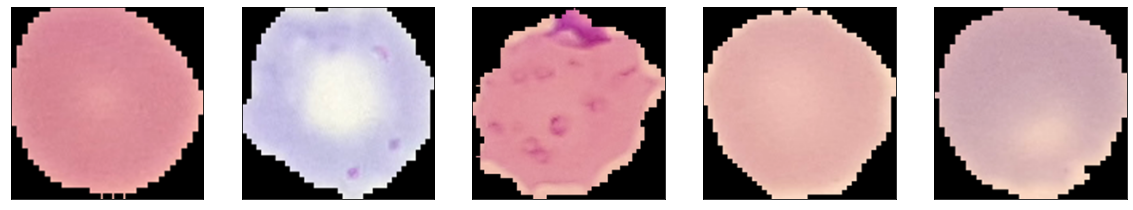

In [8]:
n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Data partitions


>  Partition the data into 10 sets.  

*   8 for teacher training
*   1 for student training
*   1 for student testing



In [9]:
partition_len = np.floor(len(labels)/10)
partition_len = int(partition_len)
print(partition_len)

2755


# The model


> For ease, I am using a pretrained VGG16 model. I freeze the layers of VGG16 and add a few trainable Dense layers on top. This is all in a function call so that we can create different models for all our teachers and student.



In [10]:
def create_model(print_model=True):
  tf.keras.backend.clear_session()

  base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')

  for x in base_model.layers:
    x.trainable = False

  input_img = Input(shape=(224, 224, 3), name='input1')
  
  x = base_model(input_img)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(1, activation='sigmoid', name='output')(x)
  
  model = Model(input_img, output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(name='acc')])
  if print_model:
    model.summary()
  return model

In [11]:
imageDataGenerator2 = ImageDataGenerator(rescale=1/255.)

imageDataGenerator = ImageDataGenerator(rescale=1/255.,
                                        #  rotation_range=45,
                                        #  horizontal_flip=True,
                                        #  vertical_flip=True
                                        )

Slice the data to create the public training data.

In [12]:
start = 8*partition_len
end = 9*partition_len
images_public = images[start:end]
images_public = np.asarray(images_public)
labels_public = labels[start:end]
labels_public = np.asarray(labels_public)

# Teacher training


> Now I train each teacher on their own private training data (not shared with any other teacher or the student. Then I have each teacher make predictions for the public training data.



In [14]:
teacher_predictions = []

total_data_len = partition_len*8
data_len = np.floor(total_data_len/num_teachers)
data_len = int(data_len)
print('data_len = ' + str(data_len))

print_model = True
for n in range(num_teachers):
  start = n*data_len
  end = (n+1)*data_len
  images_p = images[start:end]
  images_p = np.asarray(images_p)
  labels_p = labels[start:end]
  labels_p = np.asarray(labels_p)
  train_gen = imageDataGenerator.flow(images_p, labels_p, seed=seed, batch_size=16)
  model = create_model(print_model)
  print_model = False
  model.fit(train_gen, epochs=EPOCHS, verbose=0)
  print(' Teacher ' + str(n+1) + ' training completed.')
  pred_gen = imageDataGenerator2.flow(images_public, labels_public, shuffle=False)
  preds = model.predict(pred_gen, verbose=0)
  teacher_predictions.append(preds)
  print(' Predictions for teacher ' + str(n+1) + ' done')
  metrics = model.evaluate(pred_gen, verbose=0)
  print('accuracy = ' + str(metrics[1]))

data_len = 2755
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)    

# Teacher voting

> Create new labels from teacher voting for public training data:



1.   Tally yes and no votes from teacher predictions
2.   Add noise to the vote counts
3.   Label public training data with the winner of the votes




In [15]:
start = 8*partition_len
end = 9*partition_len
labels_public = labels[start:end]

mu, sigma = 0, 0.1 

preds_public = []
for i in range(len(labels_public)):
  yes_votes = 0
  no_votes = 0
  for t in range(num_teachers):
    prediction = teacher_predictions[t][i]
    if prediction > 0.5:
      yes_votes += 1
    else:
      no_votes += 1
  # add guassian noise to the vote counts
  noise = np.random.normal(mu, sigma)  
  yes_votes += noise
  noise = np.random.normal(mu, sigma)  
  no_votes += noise

  if yes_votes >= no_votes:
    preds_public.append(1)
  else: 
    preds_public.append(0)

How did our Teacher aggregate do?

In [16]:
m = tf.keras.metrics.BinaryAccuracy()
_ = m.update_state(labels_public, preds_public)
print(m.result().numpy())

0.9306715


# Student training



> **Note** that we are using the labels from the Teacher voting and not the labels from the public training data. The idea is that the student can be trained on unlabeled data because the teachers provide the labels via the voting process.



In [17]:
preds_public = np.asarray(preds_public)
train_gen = imageDataGenerator.flow(images_public, preds_public, seed=seed)
student_model = create_model(print_model=False)
student_model.fit(train_gen, epochs=EPOCHS, verbose=0)

# Student predictions


> Now I have a trained student model (who has never seen the private data, nor has any knowledge of the Teacher model architectures used. So let's run some predictions on our public test data.



In [20]:
start = 9*partition_len
end = 10*partition_len
images_test = images[start:end]
images_test = np.asarray(images_test)
labels_test = labels[start:end]
labels_test = np.asarray(labels_test)
test_gen = imageDataGenerator2.flow(images_test, labels_test, seed=seed, shuffle=False)
metrics = student_model.evaluate(test_gen, verbose=0)
print('accuracy = ' + str(metrics[1]))

accuracy = 0.8852994441986084


# Privacy analysis


> Now to analyze the differential privacy guarantees of this PATE implementation.



In [19]:
# TODO: Create a baseline and then perform analysis